In [1]:
import tensorflow as tf
from tqdm import tqdm
from google.colab import runtime
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
import numpy as np

2025-07-27 05:12:32.723172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753593153.085394      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753593153.187716      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the data

In [2]:
(train_ds, test_ds) = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=False,
    with_info=False,
    batch_size = 64
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1753593179.198250      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753593179.199000      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Shuffling /root/tensorflow_datasets/mnist/incomplete.S42685_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.S42685_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [4]:
combined_dataset = train_ds.concatenate(test_ds) # We're generating new images, so test set doesn't make sense here

In [5]:
images_only_dataset = combined_dataset.map(lambda features_dict: features_dict['image'])

In [6]:
IMG_PREPROCESSOR = tf.keras.Sequential([tf.keras.layers.Resizing(64,64), tf.keras.layers.Rescaling(1.0/255)])

In [7]:
images_only_dataset = images_only_dataset.map(IMG_PREPROCESSOR)

In [8]:
processed_dataset = combined_dataset.map(lambda feature_dict: {'image': IMG_PREPROCESSOR(feature_dict['image']), 'label': feature_dict['label']})

## Visualize the data

In [9]:
def plot_img(img):
    plt.imshow(img)
    plt.show()

## Defining VAE components

In [10]:
class GaussianNoise():
    def sample(self, inputs):
        mu, logvar = inputs
        return tfp.distributions.Normal(loc = mu, scale = tf.math.exp(logvar * 0.5)).sample()

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters = 4, kernel_size = 3, strides=2, padding = 'same', activation='leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides=2, padding = 'same', activation='leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides=2, padding = 'same', activation='leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides=2, padding = 'same', activation='leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides=2, padding = 'same', activation='leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
        ])
        self.mu = tf.keras.layers.Dense(units = 32)
        self.logvar = tf.keras.layers.Dense(units = 32)
        self.noise = GaussianNoise()

    def call(self, x):
        x = self.model(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.noise.sample((mu, logvar))
        return mu, logvar, z

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units = 2*2*32, activation='leaky_relu'),
            tf.keras.layers.Reshape((2,2,32)),
            tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = 3, strides = 2, padding = 'same', activation = 'leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2, padding = 'same', activation = 'leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(filters = 4, kernel_size = 3, strides = 2, padding = 'same', activation = 'leaky_relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2, padding = 'same', activation = 'sigmoid'),
            tf.keras.layers.BatchNormalization(),
        ])

    def call(self, x):
        return self.model(x)

## Defining loss functions

In [13]:
reconstruction_loss_fn = tf.keras.losses.MeanSquaredError(
    name='mean_squared_error'
)

In [14]:
def kl_loss(mu, logvar):
    return -0.5 * tf.reduce_mean(tf.reduce_sum((1 + logvar - tf.square(mu) - tf.exp(logvar)), axis = 1))

In [15]:
RECONSTRUCTION_LOSS_WEIGHT = 300
def reconstruction_loss(original, reconstructed):
    return tf.reduce_mean(reconstruction_loss_fn(original, reconstructed) * RECONSTRUCTION_LOSS_WEIGHT)

## Setup VAE

In [16]:
class VAE(tf.keras.Model):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss = tf.keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss = tf.keras.metrics.Mean(name = 'reconstruction_loss')
        self.kl_loss = tf.keras.metrics.Mean(name = 'kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss,
            self.reconstruction_loss,
            self.kl_loss
        ]

    def call(self, inputs):
        mu, logvar, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return mu, logvar, reconstructed

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            mu, logvar, reconstructed = self(inputs)
            reconstruction_loss_value = reconstruction_loss(inputs, reconstructed)
            kl_loss_value = kl_loss(mu, logvar)
            total_loss = reconstruction_loss_value + kl_loss_value
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss_value)
        self.kl_loss.update_state(kl_loss_value)
        return {"total_loss": self.total_loss.result(), "reconstruction_loss": self.reconstruction_loss.result(), "kl_loss": self.kl_loss.result()}

## Setup 2D visualization of latent space

In [17]:
class LatentSpace2D():
    def __init__(self):
        self.pca = PCA(n_components=3)

    def visualize(self, data):
        self.pca.fit(data['encoded_version'])
        transformed_data = self.pca.transform(data['encoded_version'])
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        im = ax.scatter3D(transformed_data[:,0], transformed_data[:,1], transformed_data[:,2], c = data['labels'], cmap='summer')
        plt.colorbar(im)
        plt.show()

## Setup training

In [18]:
EPOCHS = 20
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder,decoder)
vae.compile(optimizer='adam')
vae.fit(images_only_dataset, epochs = EPOCHS, batch_size = 64)
# for epoch in range(EPOCHS):
#     met = {}
#     for batch in tqdm(images_only_dataset):
#         met = vae.train_step(batch, epoch)
#     print(met)

Epoch 1/20


I0000 00:00:1753593247.017940     106 service.cc:148] XLA service 0x7a53c0005230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753593247.019567     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753593247.019588     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753593247.959315     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  24/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - kl_loss: 0.0038 - reconstruction_loss: 63.5403 - total_loss: 63.5442   

I0000 00:00:1753593254.091932     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - kl_loss: 0.6164 - reconstruction_loss: 25.5214 - total_loss: 26.1378
Epoch 2/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kl_loss: 2.4791 - reconstruction_loss: 12.7772 - total_loss: 15.2563
Epoch 3/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kl_loss: 3.1034 - reconstruction_loss: 11.5265 - total_loss: 14.6299
Epoch 4/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - kl_loss: 3.5822 - reconstruction_loss: 10.6127 - total_loss: 14.1949
Epoch 5/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 3.8040 - reconstruction_loss: 10.1688 - total_loss: 13.9728
Epoch 6/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 3.9063 - reconstruction_loss: 9.9396 - total_loss: 13.8458
Epoch 7/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 3.9986 - reconstruction_loss: 9.7664 - total_loss: 13.7651
Epoch 8/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 4.0979 - reconstruction_loss: 9.6352 - total_loss: 13.7331
Epoch 9/20
1

## Test image reconstructions

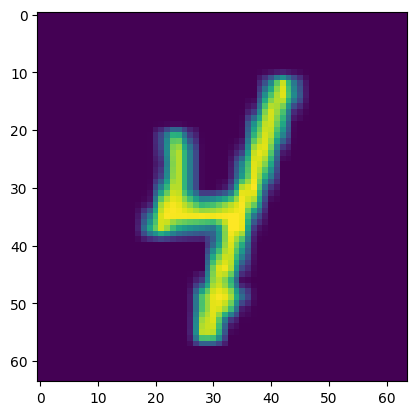

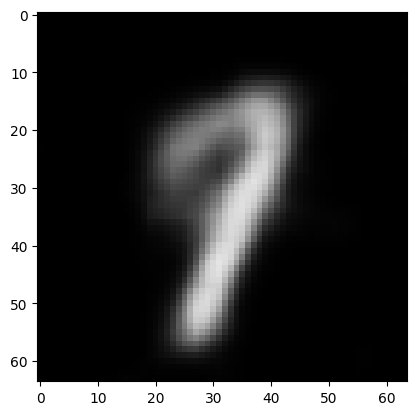

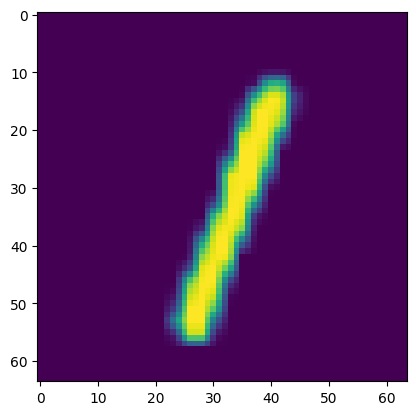

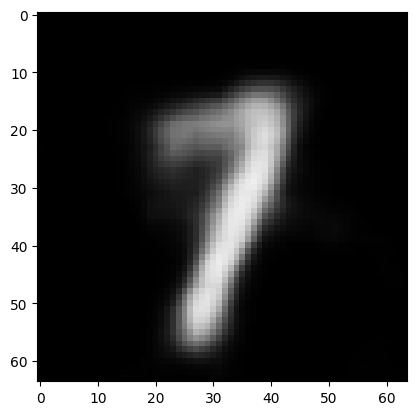

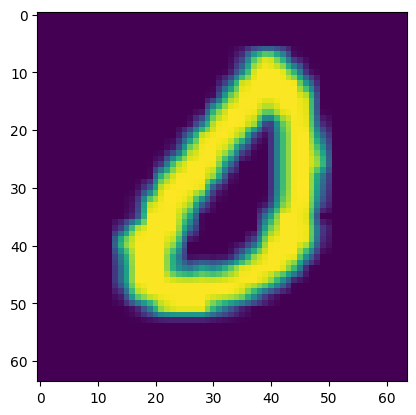

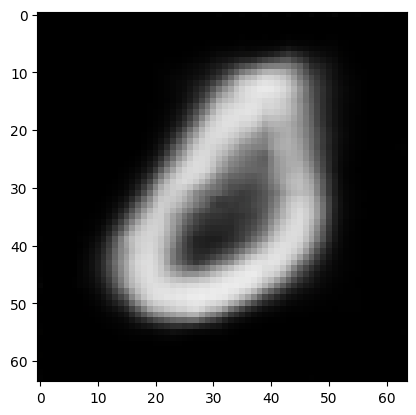

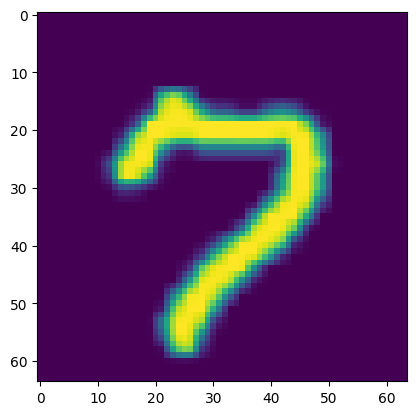

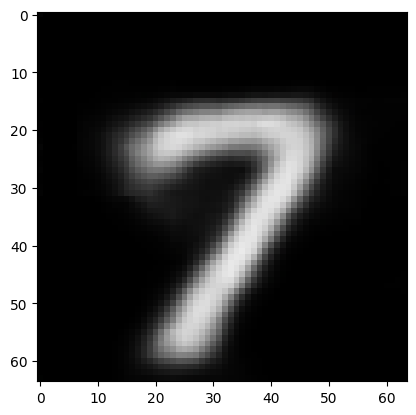

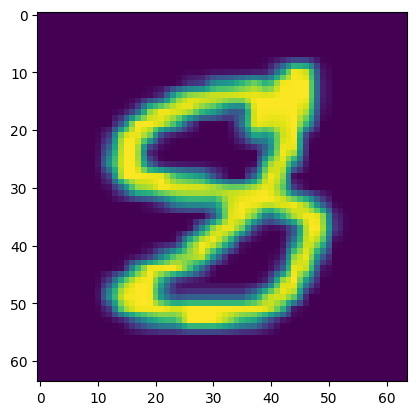

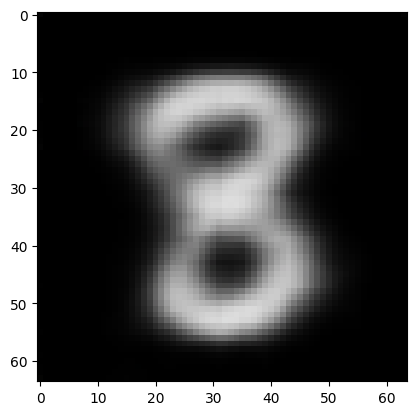

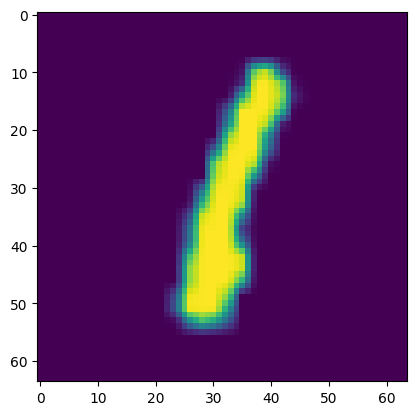

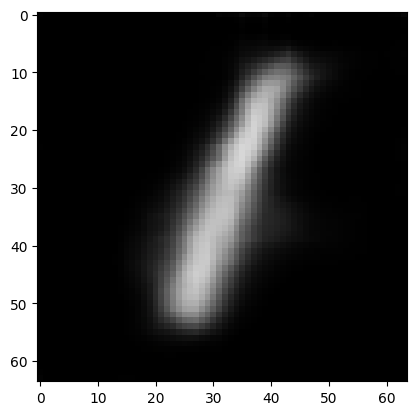

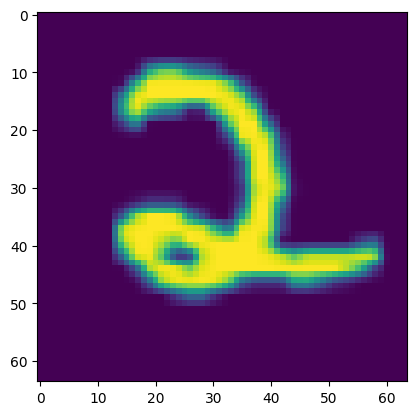

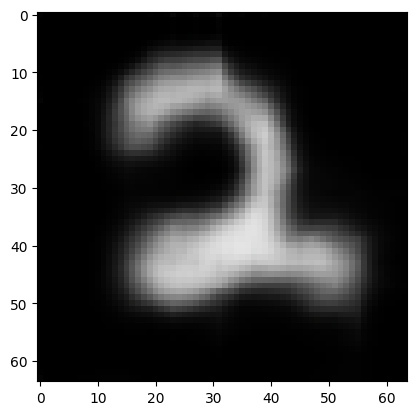

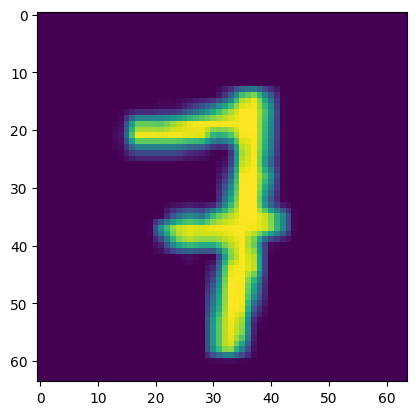

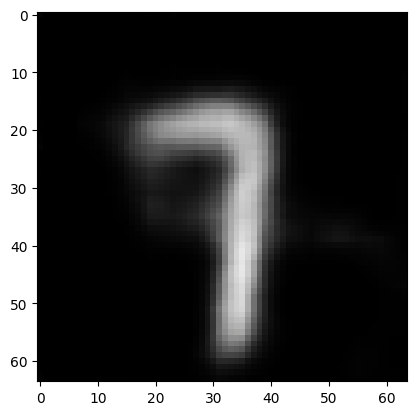

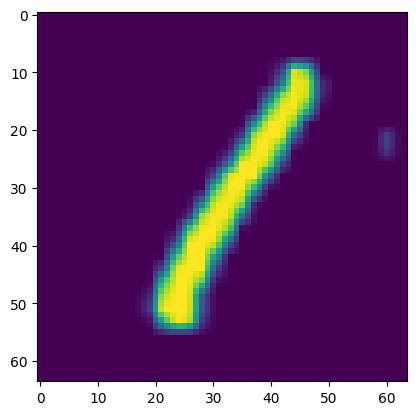

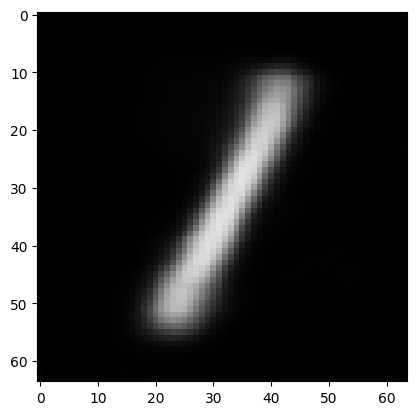

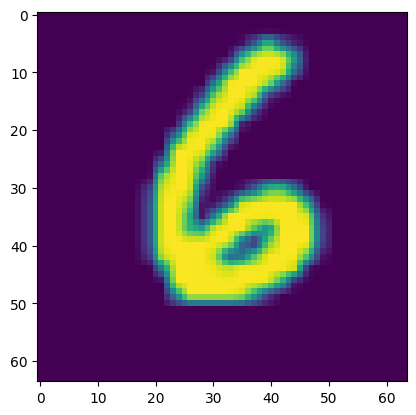

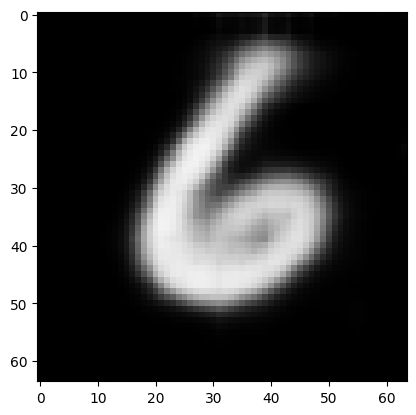

In [19]:
img = list(images_only_dataset.take(1).as_numpy_iterator())
mu, logvar, reconstructed = vae.call(img[0])
for i in range(min(len(img[0]), 10)):
    plot_img(img[0][i])
    plot_img(reconstructed[i])

In [20]:
vae.save('VAE.keras')

## Visualize latent space using PCA

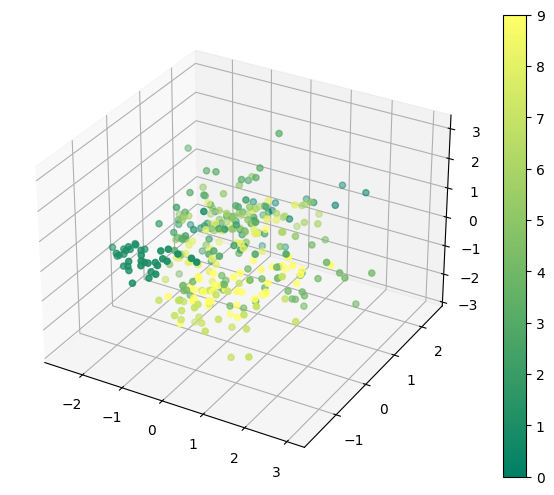

In [23]:
pca = LatentSpace2D()

latent_space = {'encoded_version': [], 'labels': []}
for data in processed_dataset.take(5):
    encoder_output = encoder(data['image'])
    latent_space['encoded_version'].append(encoder_output[0].numpy().squeeze())
    latent_space['labels'].append(data['label'])

latent_space['encoded_version'] = np.concatenate(latent_space['encoded_version'], axis = 0)
latent_space['labels'] = np.concatenate(latent_space['labels'], axis=0)
pca.visualize(latent_space)